# Assignment 3: Word Sense Disambiguation
Author: Noa Onoszko

In this assignment, we will look at three different neural architectures for word-sense disambiguation. The problem at hand is to discern what sense a certain word has in a sentence. For example, orange can mean a fruit or a color, which is evident for a human reader. Now we will train a neural network to be able to do this.

For this task, we will use the WordNet dataset that consists of the following:
- the WordNet sense key identifying the sense, as discussed above,
- a WordNet entry identifier, which we will refer to as the "lemma", in this case line as a noun,
- the position of the word that should be disambiguated,
- the tokenized text containing the word to disambiguate and its context,

We begin with some necessary imports that will be used throughout the code.

In [17]:
from tqdm.notebook import tqdm
from tqdm.auto import trange
from collections import *

import numpy as np
import matplotlib.pyplot as plt

## MFS baseline
We begin with the most frequent sense baseline, to compare our future results with. 

In [2]:
class MFS:
    def __init__(self):
        self.ws_freqs = dict()
        pass

    def train(self, x, y):
        for l in range(len(y)):
            word = x[l][0].split(".")[0]
            sense_key = y[l]

            # Update counter
            if word not in self.ws_freqs:
                self.ws_freqs[word] = Counter()
            self.ws_freqs[word][sense_key] += 1

    def test(self, x, y):
        total_examples = 0
        correct_examples = 0
        out_of_vocab = 0
        for l in range(len(y)):
            word = x[l][0].split(".")[0]
            sense_key = y[l]
            if word in self.ws_freqs:
                total_examples += 1
                if sense_key == self.ws_freqs[word].most_common(1)[0][0]:
                    correct_examples += 1
            else:
                out_of_vocab += 1
        return correct_examples / total_examples, out_of_vocab

### Load data
Load training and validation data from one file, containing 76049 data points, and test data from another, containing 13301 datapoints.

In [65]:
# Train and validation data
x_train_and_val = []
y_train_and_val = []
f = open("../data/a3_data/wsd_train.txt", "r")
for l, line in enumerate(f):
    line = line.lower().split()
    x_train_and_val.append(line[1:])
    y_train_and_val.append(line[0])

# Test data
x_test = []
y_test = []
f = open("../a3_test/wsd_test.txt", "r")
for l, line in enumerate(f):
    line = line.lower().split()
    x_test.append(line[1:])
    y_test.append(line[0])

### Train and test
We "train" (it's a stretch calling it training, we merely calculate the frequencies) the mfs model and calculate the accuracy on the test set. It is 33%, so if we do better than this we know that we are doing something right. We also check for out of vocabulary words, in this case words in the test set that do not appear in the training set. We find that there are no such words.

In [4]:
# Train and test most-frequent-sense baseline model
def dataloader_mfs(x_all, y_all, n_train=70049, n_test=6000):
    x_train = x_all[:n_train]
    y_train = y_all[:n_train]
    x_test = x_all[n_train:n_train+n_test]
    y_test = y_all[n_train:n_train+n_test]
    return x_train, y_train, x_test, y_test

unique_words = [x[0].split(".")[0] for x in x_train_and_val]
unique_words = set(unique_words)
x_train, y_train, x_test, y_test = dataloader_mfs(x_train_and_val, y_train_and_val)
mfs = MFS()
mfs.train(x_train, y_train)
accuracy, out_of_vocab = mfs.test(x_test, y_test)
print("accuracy:", accuracy, "\nout_of_vocab:", out_of_vocab)

accuracy: 0.3313333333333333 
out_of_vocab: 0


## Preparation for the neural network models
### Prepare input data
Before we can run any models, we need to prepare our input data. For all architectures, we will use one predictive model per target word (not to confuse with target of a neural network). For this reason, we create dicts for training, validation and test data, both input targets. Our input, x, will be a series of words embedded with GloVe, which means that each word is represented as an array of real numbers. The targets are one-hot encoded.

In [5]:
def dataloader_helper(x, y, max_doc_length, class_to_int_all_words, unique_words, window_size):
    # Create sets
    x_dict = dict()        
    y_dict = dict()
    for d, doc in enumerate(tqdm(x)):
        word = doc[0].split(".")[0]
        n_words = len(doc[2:])
        n_classes = len(class_to_int_all_words[word])
        if word not in x_dict:
            x_dict[word] = []
            y_dict[word] = []

        # Set the 1 in the one-hot target vector
        y_dict[word].append(np.zeros(n_classes))
        y_dict[word][-1][class_to_int_all_words[word][y[d]]] = 1
        
        # Create array where each row is the embedding a word in document d that exists in GloVe
        # Using window
        if window_size:
            position = int(doc[1])
            x_d = np.zeros((2 * window_size, glove_size))
            w = 1
            while 2 + position - w >= 2 and w <= window_size:
                if doc[2+position - w] in wordvecs:
                    x_d[window_size-w, :] = wordvecs[doc[2+position - w]]
                w += 1
            w = 1
            while 2+position + w <= len(doc)-1 and w <= window_size:
                if doc[2+position + w] in wordvecs:
                    x_d[window_size-1+w, :] = wordvecs[doc[2+position + w]]
                w += 1
            x_dict[word].append(x_d)
        
        # Using whole document
        else:
            x_d = np.zeros((max_doc_length, glove_size))
            for word_idx in range(n_words):
                if doc[2+word_idx] in wordvecs:
                    x_d[word_idx, :] = wordvecs[doc[2+word_idx]]
            x_dict[word].append(x_d)


    # Convert from list of 2d arrays to 3d array
    for word in unique_words:
        x_dict[word] = np.dstack(x_dict[word])
        x_dict[word] = np.moveaxis(x_dict[word], -1, 0)
        y_dict[word] = np.dstack(y_dict[word])
        y_dict[word] = np.moveaxis(y_dict[word], -1, 0)
        y_dict[word] = np.squeeze(y_dict[word])
    return x_dict, y_dict

def dataloader(x_train_and_val, y_train_and_val, n_train=70049, n_val=6000, x_test=False, y_test=False, window_size=False):
    # Calculate max document length
    max_doc_length = 0
    for d, doc in enumerate(x_train_and_val):
        max_doc_length = len(doc[2:]) if len(doc[2:]) > max_doc_length else max_doc_length
    for d, doc in enumerate(x_test):
        max_doc_length = len(doc[2:]) if len(doc[2:]) > max_doc_length else max_doc_length
    
    # Create list with unique words
    unique_words_train = []
    unique_words_val = []
    for doc in x_train_and_val[:n_train]:
        word = doc[0].split(".")[0]
        unique_words_train.append(word) if word not in unique_words_train else True
    for doc in x_train_and_val[n_train:n_train+n_val]:
        word = doc[0].split(".")[0]
        unique_words_val.append(word) if word not in unique_words_val else True

    # Create dict of dicts for each word with class as key and int as value
    class_to_int_all_words = dict()
    classes_all_words = dict()
    for d, doc in enumerate(x_train_and_val):
        word = doc[0].split(".")[0]
        if word not in classes_all_words:
            classes_all_words[word] = []
        classes_all_words[word].append(y_train_and_val[d]) if y_train_and_val[d] not in classes_all_words[word] else True
    for w, word in enumerate(set(unique_words_train) | set(unique_words_val)):
        class_to_int_all_words[word] = dict(zip(classes_all_words[word], range(len(classes_all_words[word]))))
    
    x_train_dict, y_train_dict = dataloader_helper(x_train_and_val[:n_train], y_train_and_val[:n_train], max_doc_length, class_to_int_all_words, unique_words_train, window_size)
    x_val_dict, y_val_dict = dataloader_helper(x_train_and_val[n_train:n_train+n_val], y_train_and_val[n_train:n_train+n_val], max_doc_length, class_to_int_all_words, unique_words_val, window_size)
    
    if x_test and y_test:
        x_test_dict, y_test_dict = dataloader_helper(x_test, y_test, max_doc_length, class_to_int_all_words, unique_words_val, window_size)
        return x_train_dict, y_train_dict, x_val_dict, y_val_dict, x_test_dict, y_test_dict
    else:
        return x_train_dict, y_train_dict, x_val_dict, y_val_dict

We use the word embedding GloVe with embedding size 50. We use the helper function `load_glove` from the module `glove.py` taken from the implementation by Kågebäck and Salomonsson proposed in their article Word Sense Disambiguation using a Bidirectional LSTM. The code can be found here: https://bitbucket.org/salomons/wsd/src/master/.

In [6]:
import glove
glove_size = 50
wordvecs = glove.load_glove(50)
print("Done loading glove")

load_glove: parsing line  0
load_glove: parsing line  100000
load_glove: parsing line  200000
load_glove: parsing line  300000
Done loading glove


## Multilayer perceptron
### With the whole document as input
We begin modestly with a multilayer perceptron, ignoring the position of the target word. This is then a document classification task. As previously mentioned, we train one model per target word. First we define the model. First we flatten the input into an 1d array. Then the data is fed into one hidden dense layer with 200 neurons and RELU activation, followed by a dropout layer to prevent overfitting and an output layer with sigmoid activation. Very simple, so let us see how it performs.

In [15]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

class MLP():
    def __init__(self):
        self.model = models.Sequential()
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(200, activation='relu'))
        self.model.add(layers.Dropout(0.1))
        self.model.add(layers.Dense(n_classes, activation="sigmoid"))

# Returns data for a spefic word and adds empty dimension for channels the x_train and x_val
def data_from_dict(x_train_dict, y_train_dict, x_val_dict, y_val_dict, word):
    return np.expand_dims(x_train_dict[word], 3), y_train_dict[word], np.expand_dims(x_val_dict[word], 3), y_val_dict[word], len(y_val_dict[word][0])

Next, we train the models and save them along with the training history of accuracies.

In [8]:
# Create datasets
n_train = 70049
n_val = len(x_train_and_val) - n_train
x_train_dict, y_train_dict, x_val_dict, y_val_dict, x_test_dict, y_test_dict = dataloader(x_train_and_val, y_train_and_val, n_train, n_val, x_test=x_test, y_test=y_test, window_size=False)

model_dict = dict()
history_dict = dict()
for word in tqdm(unique_words):
    x_train_word, y_train_word, x_val_word, y_val_word, n_classes = data_from_dict(x_train_dict, y_train_dict, x_val_dict, y_val_dict, word)

    # Train
    mlp = MLP()
    model = mlp.model
    model.compile(optimizer=tf.optimizers.Adam(lr=0.00001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    history = model.fit(x_train_word, y_train_word, epochs=100, validation_data=(x_val_word, y_val_word), verbose=0)

    # Save model and accuracies
    model_dict[word] = model
    history_dict[word] = history

100%|██████████| 30/30 [23:11<00:00, 46.37s/it]


Below are the results. The test accuracy is very different for different words. We see that word *see* has the highest accuracy, over 90%, and *build* has the lowest accuracy, just above 30%. The accuracy on the whole test set is 55%. Significantly better than the mfs baseline, but we can do better.

Total test accuracy: 0.5503333303282658


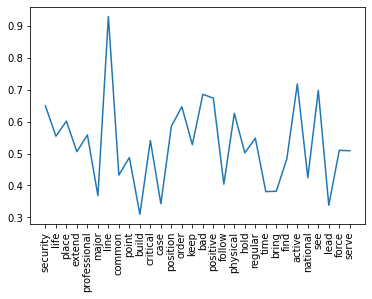

In [9]:
def test_accs_fun(x_test_dict, y_test_dict):
    test_accs = len(x_test_dict) * [0]
    for w, word in enumerate(unique_words):
        x = np.expand_dims(x_test_dict[word], 3)
        y = y_test_dict[word]
        test_accs[w] = model_dict[word].evaluate(x, y, verbose=0)[1]
    return test_accs


def total_test_acc_fun(test_accs, x_test_dict):
    global unique_words
    return sum([test_accs[w] * x_test_dict[word].shape[0] for w, word in enumerate(unique_words)]) / sum([x_test_dict[word].shape[0] for word in unique_words])

test_accs = test_accs_fun(x_test_dict, y_test_dict)
total_test_acc = total_test_acc_fun(test_accs, x_test_dict)
print("Total test accuracy:", total_test_acc)

plt.plot(list(unique_words), test_accs)
plt.xticks(rotation=90)
plt.show()

Below we can see the training and validation accuracies for three different words. The validation accuracy converges after about 30 epochs. After that, it does not show any significant decrease, perhaps thanks to the dropout layer.

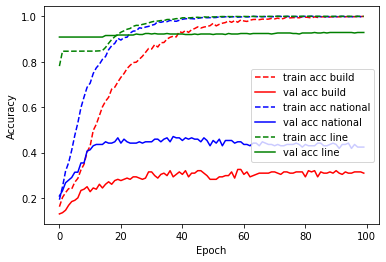

In [10]:
# Plot accuracy
cols = ["red", "blue", "green"]
for w, word in enumerate(["build", "national", "line"]):
    history = history_dict[word]
    plt.plot(history.history['accuracy'], label='accuracy', linestyle="--", color=cols[w])
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy', color=cols[w])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

plt.legend(["train acc build", "val acc build", "train acc national", "val acc national", "train acc line", "val acc line"])
plt.show()

### With neighbors to the target word as input
Next, let us try the same model for each word but instead of inputting the whole document, we input the three preceding and three succeeding words of the target word.  

The accuracy bumped up all the way tp 71%. This is reasonable, since it is the neighboring words that determine the context of the word the most. What happens in another sentence has almost no impact.

In [21]:
# Create datasets
n_train = 70049
n_val = len(x_train_and_val) - n_train
x_train_dict, y_train_dict, x_val_dict, y_val_dict, x_test_dict, y_test_dict = dataloader(x_train_and_val, y_train_and_val, n_train, n_val, x_test=x_test, y_test=y_test, window_size=3)

model_dict = dict()
history_dict = dict()
for word in tqdm(unique_words):
    x_train_word, y_train_word, x_val_word, y_val_word, n_classes = data_from_dict(x_train_dict, y_train_dict, x_val_dict, y_val_dict, word)

    mlp = MLP()
    model = mlp.model
    model.compile(optimizer=tf.optimizers.Adam(lr=0.00001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    history = model.fit(x_train_word, y_train_word, epochs=100, validation_data=(x_val_word, y_val_word), verbose=0)

    # Save model and accuracies
    model_dict[word] = model
    history_dict[word] = history
    
test_accs = test_accs_fun(x_test_dict, y_test_dict)
total_test_acc = total_test_acc_fun(test_accs, x_test_dict)
print("Total test accuracy:", total_test_acc)


Total test accuracy: 0.7061666624645392


## Convolutional neural network
A slightly more advanced approach is to use a CNN. Then, a kernel slides over the input and creates feature maps. This has a clear interpretation if the input is images. Then, the feature maps extracts different types of features in the image. In our case, we slide over words and parts of word embeddings. It is hard to imagine what features we extract in the word and word embedding space.  

The model is the same as the mlp, except that we have added a convolutional layer with 16 feature maps and a kernel of size (2, 30), followed by a spatial dropout layer to mitigate overfitting.

In [22]:
class ConvNet():
    def __init__(self):
        self.model = models.Sequential()
        self.model.add(layers.Conv2D(16, (2, 30), activation='relu', input_shape=(x_train_word.shape[1], x_train_word.shape[2], 1)))
        self.model.add(layers.SpatialDropout2D(0.1))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(200, activation='relu'))
        self.model.add(layers.Dropout(0.1))
        self.model.add(layers.Dense(n_classes, activation="sigmoid"))

Since we introduce more weights, the training will take longer. For this reason, we introduce early stopping that monitors the validation accuracy. With a patience of 20, the average number of epochs per word is 99 and the test accuracy is 73%. This is a slight improvement compared to the mlp, but it is too small to say that a convolutional layer is beneficial. It might just be the fact that we allow for more epochs (200). Since the *average* number of epochs per word is 99, there are probably some models that improve beyond 100 epochs.

In [74]:
model_dict = dict()
history_dict = dict()
for word in tqdm(unique_words):
    x_train_word, y_train_word, x_val_word, y_val_word, n_classes = data_from_dict(x_train_dict, y_train_dict, x_val_dict, y_val_dict, word)

    conv_net = ConvNet()
    model = conv_net.model
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20, verbose=0)
    model.compile(optimizer=tf.optimizers.Adam(lr=0.00001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    history = model.fit(x_train_word, y_train_word, epochs=200, validation_data=(x_val_word, y_val_word), callbacks=[early_stopping], verbose=0)

    model_dict[word] = model
    history_dict[word] = history
    
average_epochs = sum(len(history_dict[word].history["loss"]) for word in unique_words) / 30
test_accs = test_accs_fun(x_test_dict, y_test_dict)
total_test_acc = total_test_acc_fun(test_accs, x_test_dict)
print("Total test accuracy:", total_test_acc)
print("Average number of epochs:", average_epochs)

Total test accuracy: 0.7280655580887659
Average number of epochs: 99.13333333333334


## Recurrent neural networks
### Unidirectinoal LSTM
Now we move into new territory. RNN:s work well on sequence data, which is exactly what we have. We start with a unidirectinoal long-short term architecture, with hopes that it will use the relevant information and forget the rest with the help of its forget gates.

In [45]:
class UniLSTM():
    def __init__(self):
        self.model = models.Sequential()
        self.model.add(layers.LSTM(20))
        self.model.add(layers.Dropout(0.1))
        self.model.add(layers.Dense(n_classes, activation="sigmoid"))

Suprisingly, we get a lower accuracy than before, 70%.

In [86]:
model_dict = dict()
history_dict = dict()
for word in tqdm(unique_words):
    x_train_word, y_train_word, x_val_word, y_val_word, n_classes = data_from_dict(x_train_dict, y_train_dict, x_val_dict, y_val_dict, word)
    
    uni_lstm = UniLSTM()
    model = uni_lstm.model
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20, verbose=0)
    model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    history = model.fit(x_train_word.squeeze(), y_train_word, epochs=200, validation_data=(x_val_word.squeeze(), y_val_word), callbacks=[early_stopping], verbose=0)

    model_dict[word] = model
    history_dict[word] = history

average_epochs = sum(len(history_dict[word].history["loss"]) for word in unique_words) / 30
test_accs = test_accs_fun(x_test_dict, y_test_dict)
total_test_acc = total_test_acc_fun(test_accs, x_test_dict)
print("Total test accuracy:", total_test_acc)
print("Average number of epochs:", average_epochs)

Total test accuracy: 0.6936320576638388
Average number of epochs: 100.23333333333333


### Bidirectional LSTM
To conclude, we try a slightly more advanced model architecture: the bidirectional LSTM. The code is *heavily* inspired by this script that I found on github: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/28bd89ea9c07db15ebaa232328a53e03614b1c88/ML/Pytorch/Basics/pytorch_bidirectional_lstm.py. The original code is however used for classification on the MNIST database, so some modifications have been made for it to fit the problem at hand.

This model has one fundamental difference from the previous one: The data does not only travel forward, but also backward. The architecture in terms of hyperparameters is inspired by the paper by Kågebeck and Salomonsson: for example, we use a hidden size of 74 and dropout layers with `p=0.5`. Another difference compared to previous models, is that the window size is 10, meaning that the 10 preceding and 10 succeeding words to the target word is fed to the network. This is motivated by the fact that LSTM:s can forget some information and the hope is that it will only remember distant words that provide useful context.

This model takes significantly longer to train, so it was only trained on one word, *keep*. The test accuracy for this word is 81%, which suggests that this could be the best model out of those tried. 

In [72]:
"""
Example code of a simple bidirectional LSTM on the MNIST dataset.
Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
*    2020-05-09 Initial coding
"""


# Imports
import torch
import torchvision
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# My inputs
word = "keep"
n_train = 70049
n_val = len(x_train_and_val) - n_train
x_train_dict, y_train_dict, x_val_dict, y_val_dict, x_test_dict, y_test_dict = dataloader(x_train_and_val, y_train_and_val, n_train, n_val, x_test=x_test, y_test=y_test, window_size=10)
x_train_word, y_train_word, x_val_word, y_val_word, n_classes = data_from_dict(x_train_dict, y_train_dict, x_val_dict, y_val_dict, word)
x_test_word, y_test_word = x_test_dict[word], y_test_dict[word]

# Hyperparameters
input_size = glove_size
sequence_length = 2*window_size
num_layers = 1
hidden_size = 74
num_classes = n_classes
learning_rate = 0.001
batch_size = 64
num_epochs = 100

# Create a bidirectional LSTM
class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_input = nn.Dropout(p=0.5)
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
        )
        self.dropout_lstm = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout_input(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout_lstm(out)
        out = self.fc(out[:, -1, :])

        return out

def data_loader(x, y, batch_size):
    n_batches = int(x.shape[0]/batch_size) + 1
    batches = [() for j in range(n_batches)]
    for i in range(n_batches-1):
        batches[i] = (torch.tensor(x[i*batch_size:(i+1)*batch_size]), torch.tensor(y[i*batch_size:(i+1)*batch_size]))
    x_temp = torch.zeros((batch_size,)+x.shape[1:])
    y_temp = torch.zeros((batch_size,)+y.shape[1:])
    x_temp[:x.shape[0]-(n_batches-1)*batch_size] = torch.tensor(x[(n_batches-1)*batch_size:])
    y_temp[:y.shape[0]-(n_batches-1)*batch_size] = torch.tensor(y[(n_batches-1)*batch_size:])
    batches[n_batches-1] = (x_temp, y_temp)
    return batches
train_batches = data_loader(x_train_word, y_train_word, batch_size)
val_batches = data_loader(x_val_word, y_val_word, batch_size)
test_batches = data_loader(x_test_word, y_test_word, batch_size)

# Initialize network
model = BRNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in trange(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_batches): # batches
        # Get data to cuda if possible
        data = data.to(device=device).squeeze() # squeeze
        targets = targets.to(device=device)

        # forward
        scores = model(data.float())
        loss = criterion(scores, torch.argmax(targets, axis=1))

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device).squeeze()
            y = y.to(device=device)

            scores = model(x.float())
            _, predictions = scores.max(1)
            num_correct += (predictions == torch.argmax(y, 1)).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy  \
              {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()


check_accuracy(train_batches, model)
check_accuracy(val_batches, model)
check_accuracy(test_batches, model)



100%|██████████| 100/100 [03:30<00:00,  2.10s/it]
Got 4546 / 4992 with accuracy                91.07
Got 347 / 448 with accuracy                77.46
Got 778 / 960 with accuracy                81.04
